In [8]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [9]:
path="/content/drive/My Drive/Images"
annot="/content/drive/My Drive/Airplanes_Annotations"

In [10]:
train_images=[]
train_labels=[]

In [11]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [12]:
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


In [13]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_013.jpg
1 airplane_010.jpg
3 airplane_209.jpg
5 airplane_207.jpg
6 airplane_039.jpg
7 airplane_023.jpg
10 airplane_126.jpg
inside
12 airplane_235.jpg
13 airplane_190.jpg
inside
14 airplane_295.jpg
15 airplane_262.jpg
16 airplane_180.jpg
17 airplane_128.jpg
18 airplane_300.jpg
19 airplane_200.jpg
20 airplane_270.jpg
21 airplane_287.jpg
22 airplane_108.jpg
inside
23 airplane_046.jpg
24 airplane_018.jpg
25 airplane_041.jpg
inside
26 airplane_109.jpg
27 airplane_268.jpg
28 airplane_145.jpg
29 airplane_273.jpg
30 airplane_048.jpg
31 airplane_240.jpg
32 airplane_061.jpg
33 airplane_083.jpg
inside
34 airplane_248.jpg
35 airplane_134.jpg
36 airplane_194.jpg
38 airplane_269.jpg
39 airplane_052.jpg
40 airplane_178.jpg
41 airplane_033.jpg
42 airplane_310.jpg
43 airplane_131.jpg
44 airplane_071.jpg
45 airplane_275.jpg
47 airplane_211.jpg
48 airplane_303.jpg
49 airplane_202.jpg
50 airplane_226.jpg
51 airplane_030.jpg
52 airplane_318.jpg
53 airplane_160.jpg
54 airplane_009.jpg
55 airplane

In [14]:
X_new=np.array(train_images)
y_new=np.array(train_labels)

In [15]:

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()


553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [16]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="sigmoid")(X)

model_final = Model(vggmodel.input,predictions)

In [17]:
from keras.optimizers import Adam
opt=Adam(lr=0.0001)

model_final.compile(loss=keras.losses.binary_crossentropy,optimizer=opt,metrics=["accuracy"])
model_final.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer):
  def transform(self, y):
    Y = super().transform(y)
    if self.y_type_ == 'binary':
      return np.hstack((Y, 1-Y))
    else:
      return Y
  def inverse_transform(self, Y, threshold=None):
    if self.y_type_ == 'binary':
      return super().inverse_transform(Y[:, 0], threshold)
    else:
      return super().inverse_transform(Y, threshold)

lb=MyLabelBinarizer()
Y=lb.fit_transform(y_new)

X_train,X_test,y_train,y_test=train_test_split(X_new,Y,test_size=0.10)
print(X_train.shape,y_train.shape)

(27206, 224, 224, 3) (27206, 2)


In [19]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [21]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 5, epochs= 100, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.0082 - accuracy: 0.7750
Epoch 00001: val_loss improved from inf to 0.63583, saving model to ieeercnn_vgg16_1.h5
5/5 [==============================] - 15s 3s/step - loss: 1.0082 - accuracy: 0.7750 - val_loss: 0.6358 - val_accuracy: 0.8125
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.8188
Epoch 00002: val_loss improved from 0.63583 to 0.33887, saving model to ieeercnn_vgg16_1.h5
5/5 [==============================] - 23s 5s/step - loss: 0.4167 - accuracy: 0.8188 - val_loss: 0.3389 - val_accuracy: 0.8750
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8750
Epoch 00003: val_loss improved from 0.33887 to 0.30200, saving model to ieeercnn_vgg16_1.h5
5/5 [==============================] - 26s 5s/step - loss: 0.3651 - accuracy: 0.8750 - val_loss: 0.3020 - val_accuracy:

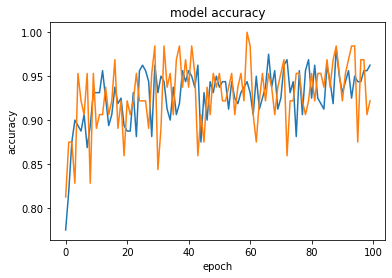

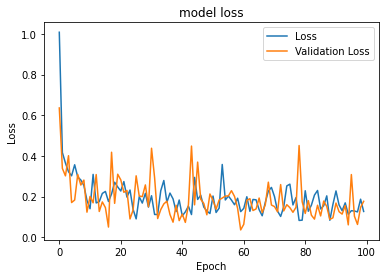

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
#plot for accuracy
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
plt.savefig('chart accuracy.png')

#plot for loss 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

plane


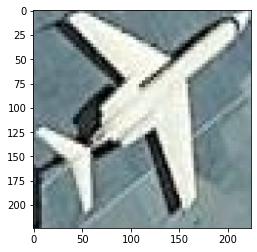

In [23]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")